# SetTransformer Histogram Prediction - W&B Sweep

대학 강의에서 학생들이 공유한 점수 샘플을 바탕으로 전체 분포를 예측하는 모델을 W&B Sweep으로 최적화합니다.

## 실행 순서
1. W&B 로그인
2. 필요한 모듈 정의
3. Sweep 실행

## 1. 패키지 설치 및 W&B 로그인

In [ ]:
!pip install wandb torch numpy scipy -q

In [ ]:
import wandb

# W&B 로그인
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hoseong8115-dev (hoseongahn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 2. 데이터 생성 모듈

In [ ]:
import numpy as np
import random
from typing import Tuple

def generate_complex_class_scores(num_students: int = 30) -> Tuple[np.ndarray, str]:
    """
    Generate scores with complex distributions.
    """
    class_type = random.choice([
        "easy", "normal", "hard", "bimodal",
        "trimodal", "uniform", "skewed_left", "skewed_right",
        "outliers", "clustered", "exponential", "beta"
    ])

    if class_type == "easy":
        mu = np.random.uniform(75, 90)
        sigma = np.random.uniform(5, 10)
        scores = np.random.normal(mu, sigma, num_students)

    elif class_type == "normal":
        mu = np.random.uniform(60, 80)
        sigma = np.random.uniform(8, 15)
        scores = np.random.normal(mu, sigma, num_students)

    elif class_type == "hard":
        mu = np.random.uniform(40, 65)
        sigma = np.random.uniform(8, 15)
        scores = np.random.normal(mu, sigma, num_students)

    elif class_type == "bimodal":
        mu1 = np.random.uniform(35, 55)
        mu2 = np.random.uniform(70, 90)
        sigma = np.random.uniform(5, 10)
        split = random.randint(num_students // 3, num_students * 2 // 3)
        scores1 = np.random.normal(mu1, sigma, split)
        scores2 = np.random.normal(mu2, sigma, num_students - split)
        scores = np.concatenate([scores1, scores2])

    elif class_type == "trimodal":
        mu1 = np.random.uniform(30, 45)
        mu2 = np.random.uniform(55, 70)
        mu3 = np.random.uniform(80, 95)
        sigma = np.random.uniform(5, 8)
        n1 = num_students // 3
        n2 = num_students // 3
        n3 = num_students - n1 - n2
        scores1 = np.random.normal(mu1, sigma, n1)
        scores2 = np.random.normal(mu2, sigma, n2)
        scores3 = np.random.normal(mu3, sigma, n3)
        scores = np.concatenate([scores1, scores2, scores3])

    elif class_type == "uniform":
        low = np.random.uniform(30, 50)
        high = np.random.uniform(70, 95)
        scores = np.random.uniform(low, high, num_students)

    elif class_type == "skewed_left":
        alpha = 2
        beta_param = 5
        scores_01 = np.random.beta(beta_param, alpha, num_students)
        scores = scores_01 * 60 + 35

    elif class_type == "skewed_right":
        alpha = 5
        beta_param = 2
        scores_01 = np.random.beta(alpha, beta_param, num_students)
        scores = scores_01 * 60 + 30

    elif class_type == "outliers":
        mu = np.random.uniform(60, 75)
        sigma = np.random.uniform(8, 12)
        scores = np.random.normal(mu, sigma, num_students)
        num_outliers = random.randint(2, min(3, num_students // 10))
        outlier_indices = random.sample(range(num_students), num_outliers)
        for idx in outlier_indices:
            if random.random() < 0.5:
                scores[idx] = np.random.uniform(0, 30)
            else:
                scores[idx] = np.random.uniform(95, 100)

    elif class_type == "clustered":
        num_clusters = random.randint(3, 5)
        cluster_centers = np.random.uniform(20, 90, num_clusters)
        cluster_std = np.random.uniform(3, 6)
        students_per_cluster = [num_students // num_clusters] * num_clusters
        for i in range(num_students % num_clusters):
            students_per_cluster[i] += 1
        scores_list = []
        for center, n in zip(cluster_centers, students_per_cluster):
            cluster_scores = np.random.normal(center, cluster_std, n)
            scores_list.append(cluster_scores)
        scores = np.concatenate(scores_list)

    elif class_type == "exponential":
        scale = np.random.uniform(15, 25)
        scores = np.random.exponential(scale, num_students)
        scores = 100 - scores

    elif class_type == "beta":
        alpha = np.random.uniform(2, 5)
        beta_param = np.random.uniform(2, 5)
        scores_01 = np.random.beta(alpha, beta_param, num_students)
        scores = scores_01 * 80 + 10

    else:
        raise ValueError(f"Unknown class type: {class_type}")

    scores = np.clip(scores, 0, 100)
    return scores, class_type


def generate_realistic_class_scores(num_students: int = 30) -> Tuple[np.ndarray, str]:
    """
    Generate scores based on realistic scenarios.
    """
    scenarios = [
        "gifted_program", "remedial_class", "mixed_ability",
        "test_anxiety", "cheating_suspected", "grade_inflation", "strict_grading"
    ]
    scenario = random.choice(scenarios)

    if scenario == "gifted_program":
        mu = np.random.uniform(85, 95)
        sigma = np.random.uniform(3, 7)
        scores = np.random.normal(mu, sigma, num_students)

    elif scenario == "remedial_class":
        mu = np.random.uniform(35, 55)
        sigma = np.random.uniform(8, 12)
        scores = np.random.normal(mu, sigma, num_students)

    elif scenario == "mixed_ability":
        mu = np.random.uniform(55, 70)
        sigma = np.random.uniform(15, 25)
        scores = np.random.normal(mu, sigma, num_students)

    elif scenario == "test_anxiety":
        prepared = int(num_students * 0.7)
        anxious = num_students - prepared
        scores_prepared = np.random.normal(75, 10, prepared)
        scores_anxious = np.random.normal(50, 15, anxious)
        scores = np.concatenate([scores_prepared, scores_anxious])

    elif scenario == "cheating_suspected":
        cheaters = int(num_students * 0.3)
        honest = num_students - cheaters
        scores_honest = np.random.normal(65, 12, honest)
        scores_cheaters = np.random.normal(95, 3, cheaters)
        scores = np.concatenate([scores_honest, scores_cheaters])

    elif scenario == "grade_inflation":
        alpha = 2
        beta_param = 5
        scores_01 = np.random.beta(beta_param, alpha, num_students)
        scores = scores_01 * 50 + 50

    elif scenario == "strict_grading":
        alpha = 5
        beta_param = 2
        scores_01 = np.random.beta(alpha, beta_param, num_students)
        scores = scores_01 * 70 + 15

    scores = np.clip(scores, 0, 100)
    return scores, scenario


def scores_to_hist(scores: np.ndarray, num_bins: int = 10) -> np.ndarray:
    """Convert scores to histogram probability distribution."""
    bins = np.linspace(0, 100, num_bins + 1)
    hist, _ = np.histogram(scores, bins=bins)
    hist_prob = hist.astype(np.float32) / len(scores)
    return hist_prob


def create_sample_target_pair(
    num_students: int = 30,
    sample_size: int = 10,
    num_bins: int = 10
) -> Tuple[np.ndarray, np.ndarray, str]:
    """
    Create training sample with advanced distributions.
    """
    distribution_type = random.choice(['complex', 'realistic'])

    if distribution_type == 'complex':
        scores_all, class_type = generate_complex_class_scores(num_students)
    else:
        scores_all, class_type = generate_realistic_class_scores(num_students)

    sample_size = min(sample_size, num_students)
    idx = np.random.choice(len(scores_all), sample_size, replace=False)
    sample_scores = scores_all[idx]

    sample_scores = np.sort(sample_scores)
    sample_scores_norm = sample_scores / 100.0

    hist_prob = scores_to_hist(scores_all, num_bins)

    return sample_scores_norm.astype(np.float32), hist_prob, class_type

print("✓ Data generation module loaded")

✓ Data generation module loaded


## 3. PyTorch Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class FlexibleScoreDistDataset(Dataset):
    """
    Dataset with variable sample sizes.
    """
    def __init__(
        self,
        num_classes: int = 5000,
        num_students_range: Tuple[int, int] = (30, 30),
        sample_size_range: Tuple[int, int] = (10, 10),
        num_bins: int = 10
    ):
        self.num_classes = num_classes
        self.num_students_range = num_students_range
        self.sample_size_range = sample_size_range
        self.num_bins = num_bins

        self.inputs = []
        self.targets = []
        self.class_types = []
        self.metadata = []

        print(f"Generating {num_classes} synthetic classes...")

        for i in range(num_classes):
            if (i + 1) % 5000 == 0:
                print(f"  Generated {i + 1}/{num_classes} classes")

            num_students = random.randint(*num_students_range)
            sample_size = random.randint(*sample_size_range)
            sample_size = min(sample_size, num_students)

            sample_scores, hist_prob, class_type = create_sample_target_pair(
                num_students=num_students,
                sample_size=sample_size,
                num_bins=num_bins
            )

            self.inputs.append(sample_scores)
            self.targets.append(hist_prob)
            self.class_types.append(class_type)
            self.metadata.append({
                'sample_size': sample_size,
                'num_students': num_students
            })

        print(f"Dataset created: {len(self)} samples")

    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.inputs[idx]
        y = self.targets[idx]
        return torch.tensor(x), torch.tensor(y)


def collate_fn_flexible(batch):
    """
    Custom collate function for variable-length sequences.
    """
    inputs, targets = zip(*batch)

    max_len = max(x.size(0) for x in inputs)

    padded_inputs = []
    masks = []

    for x in inputs:
        pad_len = max_len - x.size(0)
        if pad_len > 0:
            padded = torch.cat([x, torch.zeros(pad_len)])
            mask = torch.cat([torch.ones(x.size(0)), torch.zeros(pad_len)])
        else:
            padded = x
            mask = torch.ones(x.size(0))

        padded_inputs.append(padded)
        masks.append(mask)

    inputs = torch.stack(padded_inputs)
    masks = torch.stack(masks)
    targets = torch.stack(targets)

    return inputs, targets, masks

print("✓ Dataset module loaded")

✓ Dataset module loaded


## 4. SetTransformer 모델

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiheadAttentionBlock(nn.Module):
    """Multi-head attention block."""
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, context=None):
        if context is None:
            context = x
        attn_out, _ = self.attention(x, context, context)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ffn(x))
        return x


class SetTransformerEncoder(nn.Module):
    """Set Transformer Encoder with Inducing Points."""
    def __init__(self, dim, num_heads, num_inducers, dropout=0.1):
        super().__init__()
        self.inducing_points = nn.Parameter(torch.randn(1, num_inducers, dim))
        self.mab1 = MultiheadAttentionBlock(dim, num_heads, dropout)
        self.mab2 = MultiheadAttentionBlock(dim, num_heads, dropout)

    def forward(self, x):
        batch_size = x.size(0)
        I = self.inducing_points.expand(batch_size, -1, -1)
        H = self.mab1(I, x)
        return self.mab2(x, H)


class FlexibleHistogramPredictor(nn.Module):
    """SetTransformer-based histogram predictor."""
    def __init__(self, hidden_dim=64, num_bins=10, num_heads=4, num_inducers=16, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, hidden_dim)
        self.encoder = SetTransformerEncoder(hidden_dim, num_heads, num_inducers, dropout)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_bins),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.decoder(x)

print("✓ Model module loaded")

✓ Model module loaded


## 5. 학습 함수

In [ ]:
from torch.utils.data import DataLoader
from pathlib import Path

def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        x, y, mask = batch
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch
            x, y = x.to(device), y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

print("✓ Training functions loaded")

✓ Training functions loaded


## 6. W&B Sweep 설정

In [ ]:
SWEEP_CONFIG = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'min': 10,
            'max': 200
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'min': 1e-5,
            'max': 1e-2,
            'distribution': 'log_uniform_values'
        },
        'hidden_dim': {
            'values': [32, 64, 128, 256]
        },
        'num_heads': {
            'values': [2, 4, 8]
        },
        'num_inducers': {
            'values': [8, 16, 32, 64]
        },
        'dropout': {
            'min': 0.0,
            'max': 0.5
        },
        'optimizer': {
            'values': ['adam', 'adamw']
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-3
        }
    }
}

print("✓ Sweep configuration loaded")

✓ Sweep configuration loaded


## 7. Sweep 학습 함수

In [ ]:
def train_sweep():
    """Main training function for W&B sweep."""
    with wandb.init() as run:
        config = wandb.config

        set_seed(42)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")

        # Create datasets
        print("\n=== Creating datasets ===")
        train_dataset = FlexibleScoreDistDataset(
            num_classes=20000,
            num_students_range=(20, 50),
            sample_size_range=(5, 20),
            num_bins=10
        )
        val_dataset = FlexibleScoreDistDataset(
            num_classes=5000,
            num_students_range=(20, 50),
            sample_size_range=(5, 20),
            num_bins=10
        )

        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            collate_fn=collate_fn_flexible,
            num_workers=2
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            collate_fn=collate_fn_flexible,
            num_workers=2
        )

        # Create model
        model = FlexibleHistogramPredictor(
            hidden_dim=config.hidden_dim,
            num_bins=10,
            num_heads=config.num_heads,
            num_inducers=config.num_inducers,
            dropout=config.dropout
        )
        model = model.to(device)

        num_params = sum(p.numel() for p in model.parameters())
        wandb.log({"model_parameters": num_params})
        print(f"Model parameters: {num_params:,}")

        # Setup training
        criterion = nn.MSELoss()

        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=config.learning_rate,
                weight_decay=config.weight_decay
            )
        else:
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=config.learning_rate,
                weight_decay=config.weight_decay
            )

        # Training loop
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        best_model_state = None

        for epoch in range(config.epochs):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss = validate(model, val_loader, criterion, device)

            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
            })

            print(
                f"Epoch {epoch+1:3d}/{config.epochs} | "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f}"
            )

            # Early stopping and save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0

                # Save best model state
                best_model_state = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'config': dict(config)
                }

                # Save to file
                torch.save(best_model_state, f'best_model_{run.id}.pt')
                print(f"  → Saved best model (val_loss: {val_loss:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1}")
                    break

        wandb.log({'best_val_loss': best_val_loss})
        print(f"\n=== Best validation loss: {best_val_loss:.4f} ===")

        # Save model to W&B artifacts
        if best_model_state is not None:
            artifact = wandb.Artifact(
                name=f'model-{run.id}',
                type='model',
                metadata=dict(config)
            )
            artifact.add_file(f'best_model_{run.id}.pt')
            run.log_artifact(artifact)
            print(f"✓ Model saved to W&B artifacts")

print("✓ Sweep training function loaded")

✓ Sweep training function loaded


## 8. Sweep 실행

아래 셀을 실행하여 W&B sweep을 시작합니다.

In [ ]:
# Sweep 설정
PROJECT_NAME = "histogram-prediction-sweep"
SWEEP_COUNT = 40  # 실행할 sweep 개수

# Sweep 초기화
sweep_id = wandb.sweep(
    sweep=SWEEP_CONFIG,
    project=PROJECT_NAME
)

print(f"\n{'='*60}")
print(f"Created sweep: {sweep_id}")
print(f"{'='*60}\n")

# Sweep 실행
wandb.agent(
    sweep_id,
    function=train_sweep,
    count=SWEEP_COUNT
)

print(f"\n{'='*60}")
print(f"Sweep completed!")
print(f"{'='*60}\n")

## 9. Best 모델 불러오기 및 사용

Sweep이 완료된 후 best 모델을 불러와서 사용할 수 있습니다.

In [12]:
def find_best_sweep_run(project_name: str, sweep_id: str):
    """
    W&B sweep에서 best run을 찾습니다.

    Args:
        project_name: W&B 프로젝트 이름
        sweep_id: Sweep ID

    Returns:
        best_run: Best run 객체
        best_model_path: Best 모델 파일 경로
    """
    api = wandb.Api()

    # Sweep 정보 가져오기
    sweep = api.sweep(f"{project_name}/{sweep_id}")

    # 모든 runs 가져오기
    runs = sweep.runs

    # val_loss 기준으로 정렬
    best_run = min(runs, key=lambda run: run.summary.get('best_val_loss', float('inf')))

    print(f"{'='*60}")
    print(f"Best Run Found!")
    print(f"{'='*60}")
    print(f"Run ID: {best_run.id}")
    print(f"Run Name: {best_run.name}")
    print(f"Best Val Loss: {best_run.summary.get('best_val_loss', 'N/A'):.4f}")
    print(f"\nHyperparameters:")
    for key, value in best_run.config.items():
        print(f"  {key}: {value}")
    print(f"{'='*60}")

    # 모델 파일 경로
    best_model_path = f"best_model_{best_run.id}.pt"

    return best_run, best_model_path


def download_best_model_from_wandb(project_name: str, sweep_id: str, download_dir: str = '.'):
    """
    W&B artifacts에서 best 모델을 다운로드합니다.

    Args:
        project_name: W&B 프로젝트 이름
        sweep_id: Sweep ID
        download_dir: 다운로드할 디렉토리

    Returns:
        model_path: 다운로드된 모델 파일 경로
    """
    api = wandb.Api()

    # Best run 찾기
    best_run, expected_model_path = find_best_sweep_run(project_name, sweep_id)

    # Artifacts에서 모델 다운로드
    try:
        artifacts = best_run.logged_artifacts()
        model_artifact = None

        for artifact in artifacts:
            if artifact.type == 'model':
                model_artifact = artifact
                break

        if model_artifact:
            # Artifact 다운로드
            artifact_dir = model_artifact.download(root=download_dir)
            model_path = f"{artifact_dir}/{expected_model_path}"
            print(f"\n✓ Model downloaded from W&B artifacts")
            print(f"  Path: {model_path}")
            return model_path
        else:
            print(f"\n⚠ No model artifact found. Check local file: {expected_model_path}")
            return expected_model_path

    except Exception as e:
        print(f"\n⚠ Could not download from artifacts: {e}")
        print(f"  Try using local file: {expected_model_path}")
        return expected_model_path


# 사용 예시:
"""
# Sweep 완료 후 실행
PROJECT_NAME = "histogram-prediction-sweep"
SWEEP_ID = "uihzxodq"  # sweep 실행 시 출력된 ID

# Best 모델 찾기 및 다운로드
model_path = download_best_model_from_wandb(PROJECT_NAME, SWEEP_ID)

# 모델 로드
model, checkpoint = load_best_model(model_path)

# 예측
sample_scores = [75, 82, 68, 91, 77, 85, 73, 80, 88, 79]
predicted_hist = predict_distribution(model, sample_scores)
visualize_prediction(sample_scores, predicted_hist)
"""

print("✓ Best model finder functions ready")

✓ Best model finder functions ready


In [10]:
def predict_distribution(model, sample_scores, device='cuda'):
    """
    Predict full distribution from sample scores.

    Args:
        model: Trained model
        sample_scores: Array or list of sample scores (0-100 scale)
        device: Device to run inference on

    Returns:
        predicted_hist: Predicted histogram distribution (10 bins)
    """
    model.eval()

    # Preprocess input
    sample_scores = np.array(sample_scores)
    sample_scores = np.sort(sample_scores)
    sample_scores_norm = sample_scores / 100.0

    # Convert to tensor
    x = torch.tensor(sample_scores_norm, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        predicted_hist = model(x)

    return predicted_hist.cpu().numpy()[0]


# 사용 예시 및 시각화
def visualize_prediction(sample_scores, predicted_hist):
    """Visualize sample scores and predicted distribution."""
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Sample scores
    ax1.scatter(range(len(sample_scores)), sample_scores, alpha=0.6, s=100)
    ax1.set_xlabel('Student Index')
    ax1.set_ylabel('Score')
    ax1.set_title(f'Sample Scores (n={len(sample_scores)})')
    ax1.grid(alpha=0.3)
    ax1.set_ylim(0, 100)

    # Predicted distribution
    bins = np.linspace(0, 100, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax2.bar(bin_centers, predicted_hist, width=8, alpha=0.7, color='steelblue', edgecolor='black')
    ax2.set_xlabel('Score Range')
    ax2.set_ylabel('Probability')
    ax2.set_title('Predicted Distribution')
    ax2.grid(alpha=0.3, axis='y')
    ax2.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()


# 테스트 예시 (모델 로드 후 실행):
# sample_scores = [75, 82, 68, 91, 77, 85, 73, 80, 88, 79]
# predicted_hist = predict_distribution(model, sample_scores)
# visualize_prediction(sample_scores, predicted_hist)

print("✓ Prediction and visualization functions ready")

✓ Prediction and visualization functions ready


In [11]:
def load_best_model(model_path: str, device='cuda'):
    """
    Load the best model from checkpoint.

    Args:
        model_path: Path to the model checkpoint (e.g., 'best_model_xxxxx.pt')
        device: Device to load the model on

    Returns:
        model: Loaded model
        checkpoint: Full checkpoint dictionary with config and metadata
    """
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # Extract config
    config = checkpoint['config']

    # Create model with saved config
    model = FlexibleHistogramPredictor(
        hidden_dim=config['hidden_dim'],
        num_bins=10,
        num_heads=config['num_heads'],
        num_inducers=config['num_inducers'],
        dropout=config['dropout']
    )

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded successfully!")
    print(f"  Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Config: {config}")

    return model, checkpoint


# 사용 예시:
# model, checkpoint = load_best_model('best_model_xxxxx.pt')

print("✓ Model loading function ready")

✓ Model loading function ready


Best Run Found!
Run ID: nnj359uw
Run Name: fiery-sweep-19
Best Val Loss: 0.0024

Hyperparameters:
  epochs: 88
  dropout: 0.05682944850546906
  num_heads: 4
  optimizer: adamw
  batch_size: 128
  hidden_dim: 128
  num_inducers: 64
  weight_decay: 0.0007985312301473399
  learning_rate: 0.00094647621668309


wandb:   1 of 1 files downloaded.  



✓ Model downloaded from W&B artifacts
  Path: ./best_model_nnj359uw.pt
✓ Model loaded successfully!
  Validation loss: 0.0024
  Epoch: 75
  Config: {'batch_size': 128, 'dropout': 0.05682944850546906, 'epochs': 88, 'hidden_dim': 128, 'learning_rate': 0.00094647621668309, 'num_heads': 4, 'num_inducers': 64, 'optimizer': 'adamw', 'weight_decay': 0.0007985312301473399}


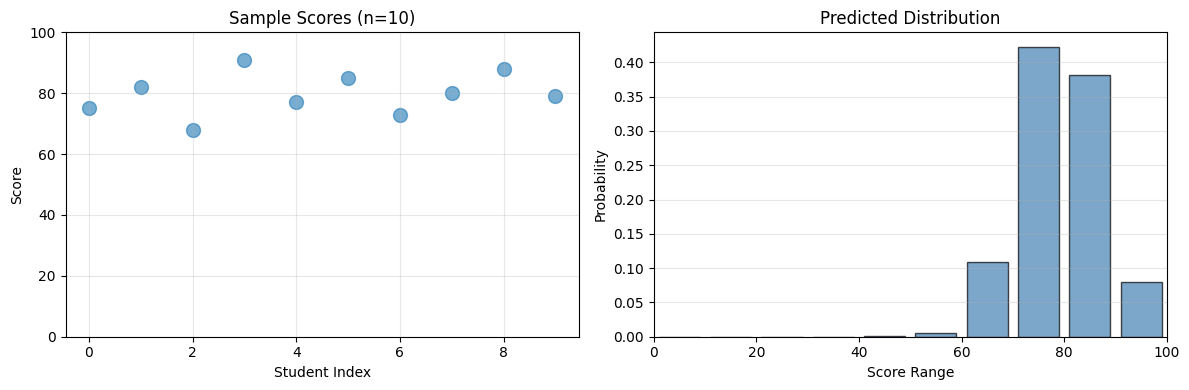

In [13]:
# Sweep 완료 후 실행
PROJECT_NAME = "histogram-prediction-sweep"
SWEEP_ID = "uihzxodq"  # sweep 실행 시 출력된 ID

# Best 모델 찾기 및 다운로드
model_path = download_best_model_from_wandb(PROJECT_NAME, SWEEP_ID)

# 모델 로드
model, checkpoint = load_best_model(model_path)

# 예측
sample_scores = [75, 82, 68, 91, 77, 85, 73, 80, 88, 79]
predicted_hist = predict_distribution(model, sample_scores)
visualize_prediction(sample_scores, predicted_hist)
